In [96]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 

# reads in all the words
words = open("names.txt", 'r').read().splitlines()

# building encoder
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

# set parameters
n_hidden = 200
n_embd = 10
numb_tests = 10000
block_size = 10 # context, number of characters taken in to predict the next
vocab_size = len(itos)


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g) # embed table, 27 rows for 27 characters, crammed into a two dimensional space(each character has a 2d embedding)
W1 = torch.randn((block_size*n_embd, n_hidden), generator=g)*(5/3)/((block_size*n_embd)**0.5)  # kaiming init for non-linear
#b1 = torch.randn(n_hidden, generator=g) * 0.01 wiped out by batch normalization's (hpreact - bnmeani)
W2 = torch.randn((n_hidden, vocab_size), generator=g)*0.01 #output is number of characters, made smaller to minimize logits on first iteration
b2 = torch.randn(vocab_size, generator=g) * 0 # makes biases all 0 and equal at initialization

# parameters of batch normalization
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden)) # replaces b1

# buffers of batch normalization
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W2, b2, W1, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

In [97]:
std = 0.2
(torch.randn(10000)*std).std()

tensor(0.2023)

In [98]:
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size # padding with [0] = '.'
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix) 
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y
 # training split, dev/validation split, test split
 # 80%, 10%, 10%
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [100]:
emb = C[Xtr]
embcat = emb.view(emb.shape[0], -1) # concatenates the vectors
hpreact = embcat @ W1  # hidden layer pre-activation, note that since the equation of self_grad of a neuron is proportional to (1-hpreact**2), this can only ever decrease, and
                           # approaches zero whenever t approaches abs(1) 
h = torch.tanh(hpreact) # activation of hidden states/hidden layer
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ytr) 

In [ ]:
lossi = []
stepi = []
batch_size = 32
# backward pass
for i in range(numb_tests):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, )) # list of 32 integers that index into the data, e.g their range is between 0 and number of data inputs,
    

    # forward pass
    emb = C[Xtr[ix]] # shape = (X.shape[0], block_size, n_hidden)
    embcat = emb.view(emb.shape[0], -1)
    
    hpreact = embcat @ W1 #+ b1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # bngain and bnbias will be 1 and 0 at init, but will be changed by back prop

    # updates batch mean and std as its running
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Ytr[ix]) # loss function
    
    for p in parameters:
        p.grad = None

    loss.backward() # updates gradients for each neuron

    # update
    lr = 0.1 if i < (numb_tests/2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad # adjust data according to gradient
    lossi.append(loss.item())
    stepi.append(i)


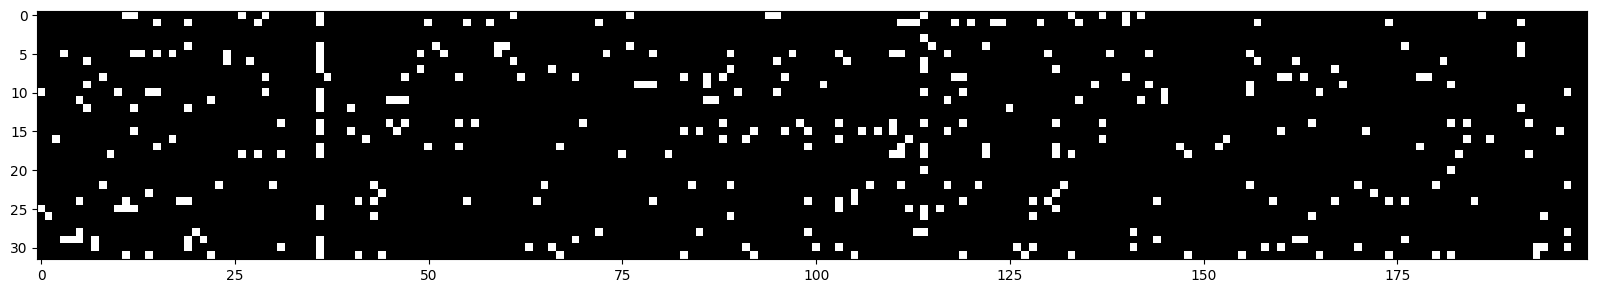

In [ ]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [ ]:
# Calibrate the batch norm at the end of training

# with torch.no_grad(): # Does not keep track of grad for this function
#     # pass the training set through
#     emb = C[Xtr]
#     embcat = emb.view(emb.shape[0], -1)
#     hpreact = embcat @ W1 + b1
#     # measure the mean/std over the entire training set, now mean/std are fixed tensors, makes sampling easier now that we don't need batch_size number of inputs to estimate h
#     bnmean = hpreact.mean(0, keepdim=True)
#     bnstd = hpreact.std(0, keepdim=True)

In [ ]:
@torch.no_grad() # decorator to disable gradient tracking for all tensors in this function
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1 # linear layer
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # now function of all examples in the batch, noise regularizes neural net
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
split_loss('train')
split_loss('val')

train 2.068458318710327
val 2.1092183589935303


In [ ]:
for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        embcat = emb.view(1, -1)
        hpreact = embcat @ W1
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

caillianord.
kenie.
veouh.
ild.
makehlie.
grishemileigh.
brodessam.
maleck.
arril.
jakyorette.
